In [140]:
import numpy as np
import matplotlib.pyplot as plt
from lib import histfit
from scipy.interpolate import make_interp_spline, BSpline

## experiment with the following data:
- MOT cycles time : 4 sec
- loading time dipole trap : 1 sec
- delay mot off excitation pulse 100 ms

In [141]:
def time_correlation(vector):
    mean = np.mean(vector)
    var = np.var(vector)
    corr = 1
    for i,i_1 in zip(vector[0:-1], vector[1:]):
        #print(i,i_1, (i-mean)*(i_1-mean))
        corr = corr + (i-mean)*(i_1-mean)/var
    return corr/len(vector)

def plot_occurrences(occurrences):
    mu = np.mean(occurrences)
    std = np.std(occurrences)
    x = np.arange(int(min(occurrences)), int(max(occurrences)))

    print("mean = ", mu, "+-", std)
    print("Q = ", std**2/mu-1)
    print("time correlation = ", time_correlation(np.array(occurrences)))

    plt.hist(occurrences, bins=x, label="measured")
    plt.xlabel("Nions")
    plt.ylabel("occurrences")
    plt.xlim([0,40])

    plt.show()
    
def get_Q(vector):
    return np.var(vector)/np.mean(vector) - 1

def Q_meaneds(vector, N_samples):
    Q_meaneds = []
    N_per_sample = int(len(vector)/N_samples)
    for i in range(N_samples):
        Q_meaneds.append(get_Q(vector[i*N_per_sample:(i+1)*N_per_sample]))
    return Q_meaneds

def means(vector, N_samples):
    means_ = []
    N_per_sample = int(len(vector)/N_samples)
    for i in range(N_samples):
        means_.append(np.mean(vector[i*N_per_sample:(i+1)*N_per_sample]))
    return means_

mean =  13.24 +- 5.22038312770241
Q =  1.0583383685800607
time correlation =  0.428203534367615


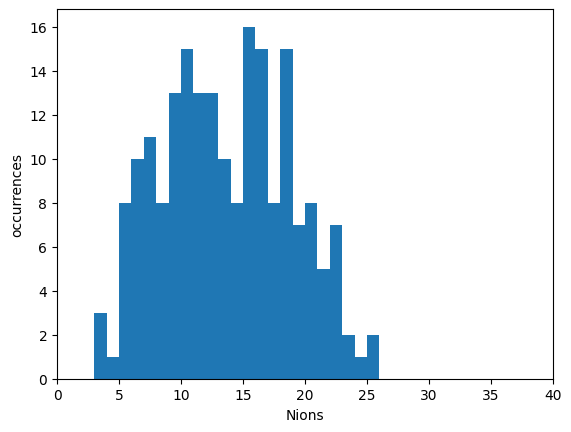

In [142]:
#names = ["F-2022-12-21-0003.txt"]
names = ["200_17_25_00"]
occurrences = []

for name in names:
    data = open("/Users/valerio/Documents/lab/Lab-Rydberg/wavw_lec_20-01-23/2023-01-25/F-2023-01-25-"+name+".txt", "r")
    for row in data:
        row = row.replace("\n", "")
        row = row.replace(",", ".")
        terms = row.split("\t")
        occurrences.append(float(terms[2]))

data, bins = np.histogram(occurrences, bins=np.arange(0,40))
plot_occurrences(occurrences)

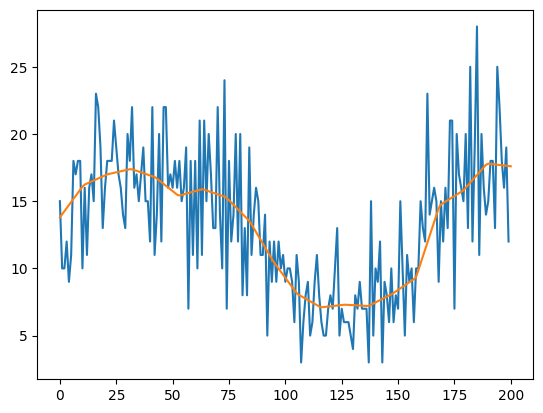

In [143]:
plt.plot(occurrences)
new_x_ = np.linspace(0, len(occurrences), 20)
new_y_ = means(occurrences, len(new_x_))
new_x = np.linspace(0, len(occurrences), len(occurrences))
new_y = np.interp(new_x, new_x_, new_y_)
plt.plot(new_x,new_y)
plt.show()

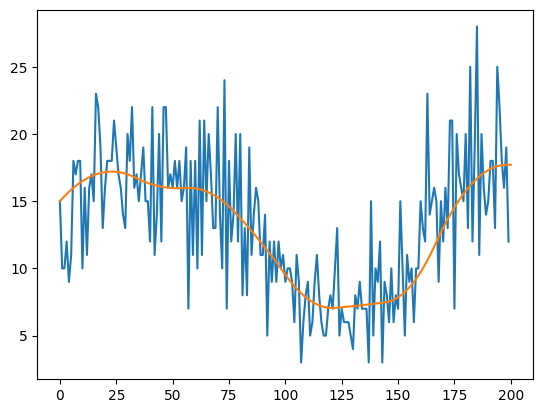

In [144]:
new_x_ = np.linspace(0, len(occurrences), 10)
new_y_ = means(occurrences, len(new_x_))

plt.plot(occurrences)
spl = make_interp_spline(new_x_, new_y_, k=2)  # type: BSpline

new_x = np.linspace(0, len(occurrences), len(occurrences))
new_y = spl(new_x)

plt.plot(new_x,new_y)
plt.show()

mean =  13.525176091252895 +- 3.608619323028183
Q =  -0.03719305902758974
time correlation =  -0.20734397902029006


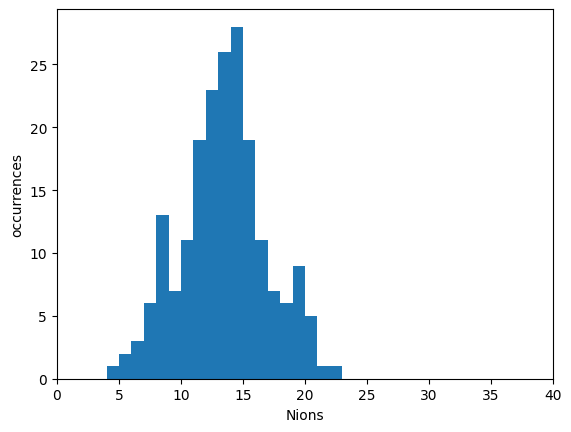

In [145]:
new_occ = np.array(occurrences) - new_y + np.mean(occurrences)
plot_occurrences(new_occ)
plt.show()
occurrences = new_occ

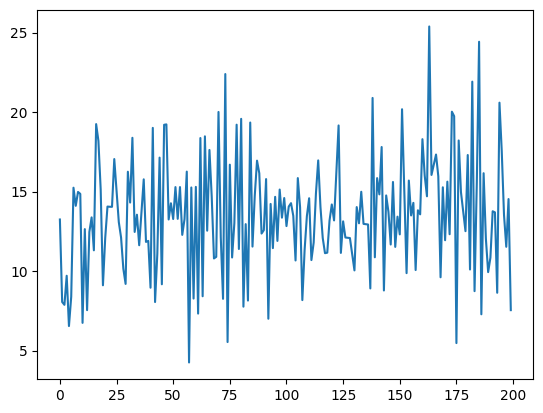

In [146]:
plt.plot(occurrences)

In [147]:
occur_rand = np.random.choice(occurrences, len(occurrences), replace=False)
time_correlation(occur_rand)

0.04101883306625691

$$ \log p_i = \log \frac{   \left(\sqrt{ \frac{R}{\beta} } \right)^{2i+\gamma/\beta-1}  }{\Gamma\left( i+1 \right) \Gamma \left( \frac{\gamma}{\beta}+i \right)  I_{\frac{\gamma}{\beta}-1} \left(2\sqrt{\frac{R}{\beta}}\right) } $$

In [148]:
data, sum(data), bins 

(array([ 0,  0,  0,  3,  1,  8, 10, 11,  8, 13, 15, 13, 13, 10,  8, 16, 15,
         8, 15,  7,  8,  5,  7,  2,  1,  2,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]),
 200,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]))

the variance for an histogram is
$$
A = \sum_i \frac{1}{p_i(\theta)} \bigg(\frac{\partial p_i(\theta)}{\partial \theta} \bigg)^2
$$
$$
Var(\theta) = \frac{1}{A}\frac{1}{N} + O(\frac{1}{N^2})
$$

In [149]:
from scipy.special import iv as BesselI
from scipy.special import gamma as Gamma
from scipy.special import loggamma as logGamma
from scipy.optimize import minimize
from scipy.misc import derivative

def log_probability_N(i_, R_beta, gamma_beta):
    #print(R_beta, gamma_beta)
    #print((1-gamma_beta)*np.log(np.sqrt(R_beta)), np.log( BesselI(gamma_beta-1, 2*np.sqrt(R_beta)) ), logGamma(gamma_beta))
    #print("\n")
    log_p_0 = -(  (1-gamma_beta)*np.log(np.sqrt(R_beta)) + np.log( BesselI(gamma_beta-1, 2*np.sqrt(R_beta)) ) + logGamma(gamma_beta) )
    log_p_i = log_p_0 + logGamma(gamma_beta) + i_*np.log(R_beta) - logGamma(i_+1) - logGamma(gamma_beta+i_)
    return log_p_i

def fit_function(theta):
    R_b = theta[0]
    g_b = theta[1]
    logL = 0
    for i  in range(len(data)):
        logL += data[i]*log_probability_N(i, R_b, g_b)
    return -logL

def variances(theta):
    R_beta = theta[0]
    gamma_beta = theta[1]
    A_R_b = 0
    A_g_b = 0
    for i in range(len(data)):
        log_p_i = log_probability_N(i, R_beta, gamma_beta)

        def fun_R_beta(theta_):
            return log_probability_N(i, theta_, theta[1])
        def fun_gamma_beta(theta_):
            return log_probability_N(i, theta[0], theta_)
        
        p_i = np.e**log_p_i
        A_R_b += 1/p_i * (derivative(fun_R_beta, theta[0])*p_i)**2
        A_g_b += 1/p_i * (derivative(fun_gamma_beta, theta[1])*p_i)**2
    return 1/(A_R_b*np.sum(data)), 1/(A_g_b*np.sum(data))
    


theta_0 = [400, 10]

theta_min = minimize(fit_function, x0=theta_0, bounds=[(0,100000),(0,100000)])

In [150]:
theta_min.x, variances(theta_min.x)

(array([4127.74735396,  299.11211783]), (6717.286017713333, 38.4364357380495))

In [151]:
log_probability_N(1,9430, 595)

-12.882034631806164

mean =  13.525176091252895 +- 3.608619323028183
Q =  -0.03719305902758974
time correlation =  -0.20734397902029006


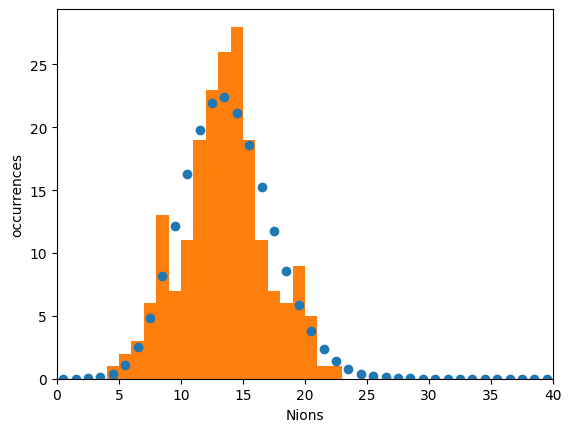

In [152]:
probs = np.array([np.e**log_probability_N(i, theta_min.x[0], theta_min.x[1]) for i in bins])
plt.plot(bins+0.5, probs*len(occurrences), "o")
plot_occurrences(occurrences)

In [153]:
N_points = 50

R_bs = 10**np.linspace(-3,3,N_points)
g_bs = 10**np.linspace(-3,3,N_points)

values = np.zeros([N_points,N_points,2])

for i, R_b in enumerate(R_bs):
    for j, g_b in enumerate(g_bs):
        values[i,j,:] = variances([R_b, g_b])

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_4011/1952884389.py:11: RuntimeWarning: invalid value encountered in sqrt
  log_p_0 = -(  (1-gamma_beta)*np.log(np.sqrt(R_beta)) + np.log( BesselI(gamma_beta-1, 2*np.sqrt(R_beta)) ) + logGamma(gamma_beta) )
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_4011/1952884389.py:12: RuntimeWarning: invalid value encountered in log
  log_p_i = log_p_0 + logGamma(gamma_beta) + i_*np.log(R_beta) - logGamma(i_+1) - logGamma(gamma_beta+i_)
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_4011/1952884389.py:11: RuntimeWarning: invalid value encountered in log
  log_p_0 = -(  (1-gamma_beta)*np.log(np.sqrt(R_beta)) + np.log( BesselI(gamma_beta-1, 2*np.sqrt(R_beta)) ) + logGamma(gamma_beta) )
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_4011/1952884389.py:11: RuntimeWarning: divide by zero encountered in log
  log_p_0 = -(  (1-gamma_beta)*np.log(np.sqrt(R_beta)) + np.log( BesselI(gamma_beta-1, 2*np.sqrt(R_bet

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_4011/2013386458.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xs, ys, c=np.log10(values[:,:,par]), cmap='viridis')


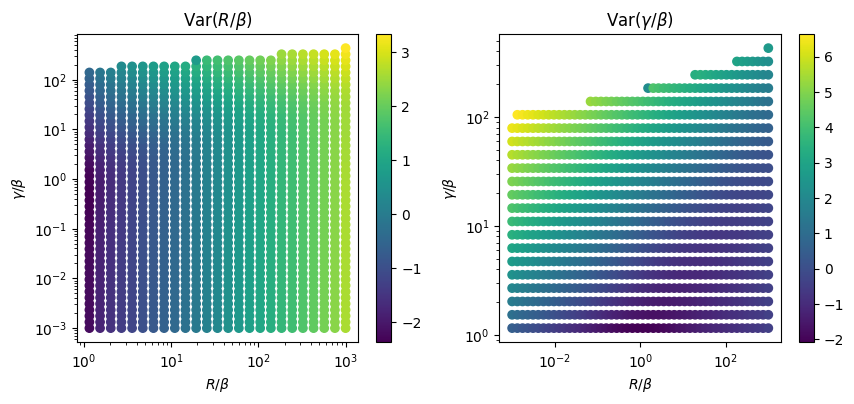

In [154]:
titles = [r"Var($R/\beta$)", r"Var($\gamma / \beta$)"]
plt.figure(figsize=(10,4))

xs = np.zeros([N_points, N_points])
ys = np.zeros([N_points, N_points])
for i in range(N_points):
    xs[:,i] = R_bs
    ys[i,:] = g_bs

for par in range(2):
    plt.subplot(1,2,par+1)
    plt.scatter(xs, ys, c=np.log10(values[:,:,par]), cmap='viridis')
    plt.title(titles[par])
    plt.ylabel(r"$\gamma/\beta$")
    plt.xlabel(r"$R/\beta$")
    plt.colorbar()
    plt.xscale("log")
    plt.yscale("log")
plt.show()

In [155]:
R_bs

array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-01,
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])

In [156]:
print(xs)

[[1.00000000e-03 1.00000000e-03 1.00000000e-03 ... 1.00000000e-03
  1.00000000e-03 1.00000000e-03]
 [1.32571137e-03 1.32571137e-03 1.32571137e-03 ... 1.32571137e-03
  1.32571137e-03 1.32571137e-03]
 [1.75751062e-03 1.75751062e-03 1.75751062e-03 ... 1.75751062e-03
  1.75751062e-03 1.75751062e-03]
 ...
 [5.68986603e+02 5.68986603e+02 5.68986603e+02 ... 5.68986603e+02
  5.68986603e+02 5.68986603e+02]
 [7.54312006e+02 7.54312006e+02 7.54312006e+02 ... 7.54312006e+02
  7.54312006e+02 7.54312006e+02]
 [1.00000000e+03 1.00000000e+03 1.00000000e+03 ... 1.00000000e+03
  1.00000000e+03 1.00000000e+03]]


In [157]:
400/60

6.666666666666667